<a href="https://colab.research.google.com/github/ralsouza/predicting_santander_customer_satisfaction/blob/main/notebooks/01_predicting_santander_customer_satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Santander Customer Satisfaction

Customer satisfaction is a key measure of success. Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving.

Santander Bank is asking to help them identify dissatisfied customers early in their relationship. Doing so would allow Santander to take proactive steps to improve a customer's happiness before it's too late.

In this project, we'll work with hundreds of anonymized features to predict if a customer is satisfied or dissatisfied with their banking experience.

Source: [Kaggle: Santander Customer Satisfaction](https://www.kaggle.com/c/santander-customer-satisfaction)

## Business Problem: 
Identify dissatisfied customers before leave the Santander services with 70% of accuracy.

# PySpark Setup

In [ ]:
!apt-get update

In [2]:
# Install the dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
# Environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [4]:
# Make pyspark "importable"
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')

In [5]:
# Libraries and Context Setup
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

In [6]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)


# Instance Spark Session
spark = SparkSession.builder.master('local').appName('spark_ml_lib').getOrCreate()

# Create the SQL Context
sqlContext = pyspark.SQLContext(sc)

In [7]:
# Create Spark Session
sp_session = SparkSession.builder.master('local').appName('app_santander_satisfaction').getOrCreate()

# Import libraries

In [9]:
from pyspark.sql import Row
from pyspark.sql.functions import col, regexp_replace, array, expr, when

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

# Load data
You are provided with an anonymized dataset containing a large number of numeric variables. The `TARGET` column is the variable to predict. It equals `one` for unsatisfied customers and `0` for satisfied customers.

The task is to predict the probability that each customer in the test set is an unsatisfied customer.

**File descriptions:**
*   train.csv - the training set including the target
*   test.csv - the test set without the target




## Train data

In [10]:
# Load train data as rdd
rdd_cust_train = sc.textFile('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/train.csv')

In [11]:
# Persist data in cache
rdd_cust_train.cache()

/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/train.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

# Transform RDD to Spark Dataframe


In [12]:
# Select header
header = rdd_cust_train.first()

In [13]:
# Remove header
rdd_cust_train2 = rdd_cust_train.filter(lambda x: x != header)

In [14]:
# Transform header as list
header_lst = header.split(',')

In [58]:
def strings_to_numbers(input):

  global header_lst

  # Transform the string position in a list separated by ,
  input_row = input.split(',')

  # Transform the strings in numbers
  row_list = [float(value) if '.' in value else float(value) for value in input_row]

  # Stores the header and values list in a dictionary
  row_dict = {header: value for (header,value) in zip(header_lst,row_list)}

  # Convert 
  row = Row(**row_dict)

  return row

In [59]:
rdd_rows = rdd_cust_train2.map(strings_to_numbers)

In [60]:
rdd_rows.take(5)

[Row(ID=1.0, TARGET=0.0, delta_imp_amort_var18_1y3=0.0, delta_imp_amort_var34_1y3=0.0, delta_imp_aport_var13_1y3=0.0, delta_imp_aport_var17_1y3=0.0, delta_imp_aport_var33_1y3=0.0, delta_imp_compra_var44_1y3=0.0, delta_imp_reemb_var13_1y3=0.0, delta_imp_reemb_var17_1y3=0.0, delta_imp_reemb_var33_1y3=0.0, delta_imp_trasp_var17_in_1y3=0.0, delta_imp_trasp_var17_out_1y3=0.0, delta_imp_trasp_var33_in_1y3=0.0, delta_imp_trasp_var33_out_1y3=0.0, delta_imp_venta_var44_1y3=0.0, delta_num_aport_var13_1y3=0.0, delta_num_aport_var17_1y3=0.0, delta_num_aport_var33_1y3=0.0, delta_num_compra_var44_1y3=0.0, delta_num_reemb_var13_1y3=0.0, delta_num_reemb_var17_1y3=0.0, delta_num_reemb_var33_1y3=0.0, delta_num_trasp_var17_in_1y3=0.0, delta_num_trasp_var17_out_1y3=0.0, delta_num_trasp_var33_in_1y3=0.0, delta_num_trasp_var33_out_1y3=0.0, delta_num_venta_var44_1y3=0.0, imp_amort_var18_hace3=0.0, imp_amort_var18_ult1=0.0, imp_amort_var34_hace3=0.0, imp_amort_var34_ult1=0.0, imp_aport_var13_hace3=0.0, imp_ap

In [72]:
# Create Spark Dataframe with headers
# The headers are converted from string to list separated by ','
train = spark.createDataFrame(rdd_rows)

In [73]:
# Show dataframe
train.show()

+----+------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+-------------------------+-------------------------+-------------------------+----------------------------+-----------------------------+----------------------------+-----------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+-------------------------+-------------------------+-------------------------+----------------------------+-----------------------------+----------------------------+-----------------------------+-------------------------+---------------------+--------------------+---------------------+--------------------+---------------------+--------------------+---------------------+--------------------+---------------------+--------------------+----------------------+---------------------+------------------+--

In [76]:
# Persist Spark Dataframe into RAM
train.cache()

DataFrame[ID: double, TARGET: double, delta_imp_amort_var18_1y3: double, delta_imp_amort_var34_1y3: double, delta_imp_aport_var13_1y3: double, delta_imp_aport_var17_1y3: double, delta_imp_aport_var33_1y3: double, delta_imp_compra_var44_1y3: double, delta_imp_reemb_var13_1y3: double, delta_imp_reemb_var17_1y3: double, delta_imp_reemb_var33_1y3: double, delta_imp_trasp_var17_in_1y3: double, delta_imp_trasp_var17_out_1y3: double, delta_imp_trasp_var33_in_1y3: double, delta_imp_trasp_var33_out_1y3: double, delta_imp_venta_var44_1y3: double, delta_num_aport_var13_1y3: double, delta_num_aport_var17_1y3: double, delta_num_aport_var33_1y3: double, delta_num_compra_var44_1y3: double, delta_num_reemb_var13_1y3: double, delta_num_reemb_var17_1y3: double, delta_num_reemb_var33_1y3: double, delta_num_trasp_var17_in_1y3: double, delta_num_trasp_var17_out_1y3: double, delta_num_trasp_var33_in_1y3: double, delta_num_trasp_var33_out_1y3: double, delta_num_venta_var44_1y3: double, imp_amort_var18_hace3:

# Exploratory data analysis

In [75]:
# Shape
print(train.count(),'x',len(train.columns))

76020 x 371


In [77]:
# Target distribuition
# Happy customers have TARGET == 0, unhappy custormers have TARGET == 1

dist_target = train.groupBy('TARGET').count() \
  .withColumn('percentage', 100 * col('count') / train.count())

dist_target.show()

+------+-----+------------------+
|TARGET|count|        percentage|
+------+-----+------------------+
|   0.0|73012| 96.04314654038411|
|   1.0| 3008|3.9568534596158904|
+------+-----+------------------+



## var3: nationality of the customer

In [78]:
# Top 20 most common values

# 116 values in column var3 are -999999
# var3 is suspected to be the nationality of the customer
# -999999 would mean that the nationality of the customer is unknown

train.groupBy('var3').count().sort(col('count').desc()).show()

+---------+-----+
|     var3|count|
+---------+-----+
|      2.0|74165|
|      8.0|  138|
|-999999.0|  116|
|      9.0|  110|
|      3.0|  108|
|      1.0|  105|
|     13.0|   98|
|      7.0|   97|
|      4.0|   86|
|     12.0|   85|
|      6.0|   82|
|      0.0|   75|
|     10.0|   72|
|     11.0|   66|
|      5.0|   63|
|     14.0|   61|
|     15.0|   34|
|     18.0|   10|
|     16.0|    9|
|     17.0|    7|
+---------+-----+
only showing top 20 rows



In [79]:
# Count -999999 values
train.filter(train['var3'] == -999999).count()

116

In [80]:
# Replace -999999 in var3 column with most common value 2 
# See https://www.kaggle.com/cast42/santander-customer-satisfaction/debugging-var3-999999
# for details

train = train.withColumn('var3', regexp_replace('var3','-999999','2'))

In [81]:
# Check replaced values
train.filter(train['var3'] == -999999).count()

0

## Add feature that counts the number of zeros in a row

In [82]:
# Removes TARGET variable
x = train.select(train.columns[:-1])

# Select only TARGET variable
y = train.select('TARGET')

# In this case, the 0s are strings
# x = x.withColumn('arr', array(*[col(i[0]) for i in x.dtypes if i[1] in ['int','bigint','string']]))\
#             .withColumn('n0', expr("""size(filter(arr,x->x==0))""")).drop('arr')

# Another simple solution to count 0s in a row
x = x.withColumn("n0", sum(when(x[col] == 0, 1).otherwise(0) for col in x.columns))

# Put n0 com x into train dataset
train3 = train.join(x.select('n0','ID'),on=['ID'],how='outer')

## num_var4 : number of bank products

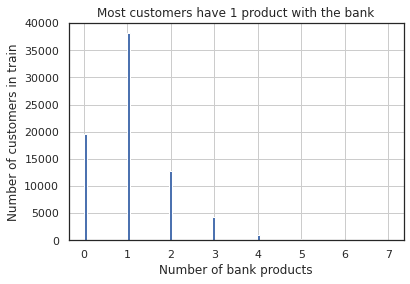

In [83]:
# According to dmi3kno (see https://www.kaggle.com/cast42/santander-customer-satisfaction/exploring-features/comments#115223)
# num_var4 is the number of products. Let's plot the distribution:
train3.toPandas().num_var4.hist(bins=100)
plt.xlabel('Number of bank products')
plt.ylabel('Number of customers in train')
plt.title('Most customers have 1 product with the bank')
plt.show()

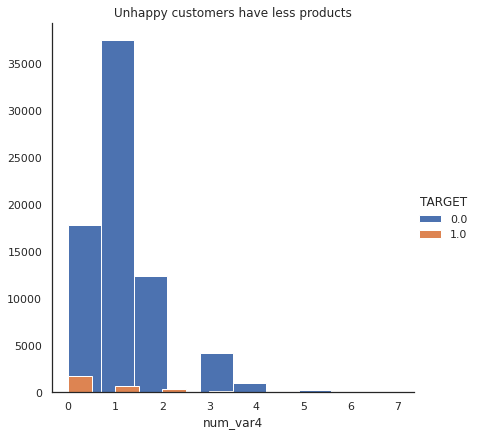

In [84]:
# Let's look at the density of the of happy/unhappy customers in function of the number of bank products
sns.FacetGrid(train3.toPandas(), hue='TARGET', size=6)\
  .map(plt.hist,'num_var4')\
  .add_legend()
plt.title('Unhappy customers have less products')
plt.show()

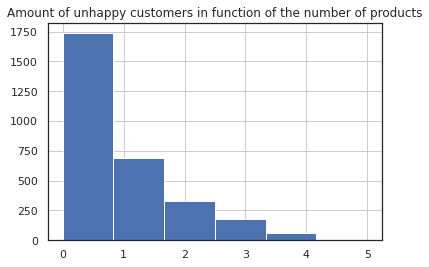

In [86]:
# Need to be orderderd like in Kaggle
train3.toPandas()[train3.toPandas().TARGET == 1].num_var4.hist(bins=6)
plt.title('Amount of unhappy customers in function of the number of products')
plt.show()

##Var38
var38 is important according to XGBOOST see https://www.kaggle.com/cast42/santander-customer-satisfaction/xgboost-with-early-stopping/files

Also RFC thinks var38 is important see https://www.kaggle.com/tks0123456789/santander-customer-satisfaction/data-exploration/notebook

Var38 is suspected to be the mortage value with the bank. If the mortage is with another bank the national average is used. See https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19895/var38-is-mortgage-value

dmi3kno says that var38 is value of the customer: https://www.kaggle.com/cast42/santander-customer-satisfaction/exploring-features/comments#115223

## Save Modified train dataset

In [ ]:
# Save dataset
train.write.save('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/train_output.parquet')

## Load saved parquet files

In [42]:
train = spark.read.parquet('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/train_output.parquet')

In [ ]:
train.cache()

DataFrame[TARGET: string]

In [52]:
# saldo_medio_var5_hace3
train.filter(train['ID'] == 32).show()

+---+----+-----+------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------+-----------------------+-----------------------+-----------------+------------------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+-----------+---------+-----------+-----------------+---------------+-----------------+---------------+-----------------+---------------+---------+-----------+---------+-----------+---------+-----------+---------+---------+-----------+---------+-----------+---------+-------------+-----------+-------------+---------+-----------+---------+-----------+-----------+---------+---------+-----------+---------+-----------+---------+-----------+---------+-------------+-----------+---------+-----------+--------